# Test

In [13]:
import pickle
import matplotlib.pyplot as plt
import torch
import numpy as np
import time

import neurite as ne
from utils import losses

from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class Args():
    def __init__(self):        
        self.batch_size = 1
        self.smooth_weight = 0.01 
        self.seg_weight = 0 
args = Args()


class Dataset_(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.image_size = images[0].shape[1:]
        self.ndims = len(self.image_size)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        outputs = [self.images[index], self.labels[index]]
        return tuple(outputs)
    
    
with open('/HDD/vxm-models/structured-data/filtered_images.pkl', 'rb') as f:
    pre_images = pickle.load(f)

with open('/HDD/vxm-models/structured-data/filtered_labels.pkl', 'rb') as f:
    pre_labels = pickle.load(f)

images, labels = [], []
for ind, img in pre_images.items():
    inp = torch.from_numpy(img)
    p_inp = torch.nn.functional.pad(inp, pad=(0, 0, 0, 0, 0, 40 - inp.shape[0]), mode='constant', value=0)
    images.append(p_inp)

for ind, img in pre_labels.items():
    inp = torch.from_numpy(img)
    p_inp = torch.nn.functional.pad(inp, pad=(0, 0, 0, 0, 0, 40 - inp.shape[0]), mode='constant', value=0)
    labels.append(p_inp)    

# Normalize        
for i, img in enumerate(images):
    images[i] = (img/img.max()).float()
for i, lb in enumerate(labels):
    labels[i] = (lb/lb.max()).float()

def get_dataloader(images, labels, batch_size, shuffle=False, pin_memory=False, workers=0):
    dataset = Dataset_(images, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory, num_workers=workers)
    return dataloader

dataloader = get_dataloader(images, labels, args.batch_size)
dice_loss_func = losses.Dice().loss

In [14]:
img, lbs = next(iter(dataloader))

In [15]:
img.shape

torch.Size([1, 40, 256, 256])

In [16]:
# i = 16
# for img, lbs in zip(images, labels):
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
#     ax1.imshow(img[i])
#     ax2.imshow(lbs[i])
#     ax3.imshow(img[i] + lbs[i])

In [17]:
import torch
import torch.nn as nn

from models.conv_lstm import ConvLSTM
from models.unet import Unet
from utils.spatial_transform import SpatialTransformer


class Unet_ConvLSTM(nn.Module):
    def __init__(self, image_size):
        super(Unet_ConvLSTM, self).__init__()
        self.image_size = image_size
        self.ndims = len(image_size)

        enc_nf = [16, 32, 32, 32]
        dec_nf = [32, 32, 32, 32, 32, 16, 16]
        self.unet = Unet(inshape=image_size, infeats=2, nb_features=[enc_nf, dec_nf])

        # configure unet to flow field layer
        Conv = getattr(nn, 'Conv%dd' % self.ndims)
        self.flow = Conv(self.unet.final_nf, self.ndims, kernel_size=3, padding=1)

        self.rnn = ConvLSTM(input_dim=2, hidden_dim=2, kernel_size=(3, 3), num_layers=1, batch_first=False)
        self.spatial_transformer = SpatialTransformer(size=image_size)

    def forward(self, images, labels=None):

        # shape of imgs/lbs: (seq_size, bs, 1, W, H)
        # shape of unet_out: (seq_size - 1, bs, 2, W, H)
        # shape of flows: (seq_size - 1, bs, 2, W, H)
        # shape of moved_images = (seq_size - 1, bs, 1, W, H)
        
        forward_sources, forward_targets = images[:-1], images[1:]
        src_trg_zip = zip(forward_sources, forward_targets)

        forward_unet_out = torch.cat([self.flow(self.unet(torch.cat([src, trg], dim=1))).unsqueeze(0) for src, trg in src_trg_zip], dim=0)
        rnn_out, last_states = self.rnn(forward_unet_out)
        h, c = last_states[0]
        forward_flows = rnn_out[0].permute(1, 0, 2, 3, 4)
        forward_moved_images = torch.cat(
            [self.spatial_transformer(src, flow).unsqueeze(0) for src, flow in zip(forward_sources, forward_flows[:])], dim=0)
        
        if labels is not None:
            forward_lbs_sources = labels[:-1]
            forward_moved_labels = torch.cat(
            [self.spatial_transformer(src, flow).unsqueeze(0) for src, flow in zip(forward_lbs_sources, forward_flows[:])], dim=0)

            
        backward_sources, backward_targets = images[1:], images[:-1]
        src_trg_zip = zip(backward_sources, backward_targets)
        backward_unet_out = torch.cat([self.flow(self.unet(torch.cat([src, trg], dim=1))).unsqueeze(0) for src, trg in src_trg_zip], dim=0)
        rnn_out, last_states = self.rnn(backward_unet_out)
        h, c = last_states[0]
        backward_flows = rnn_out[0].permute(1, 0, 2, 3, 4)
        backward_moved_images = torch.cat(
            [self.spatial_transformer(src, flow).unsqueeze(0) for src, flow in zip(backward_sources, backward_flows[:])], dim=0)
        
        if labels is not None:
            backward_lbs_sources = labels[1:]
            backward_moved_labels = torch.cat(
            [self.spatial_transformer(src, flow).unsqueeze(0) for src, flow in zip(backward_lbs_sources, backward_flows[:])], dim=0)
            return forward_moved_images, forward_moved_labels, backward_moved_images, backward_moved_labels
        else:
            return forward_moved_images, backward_moved_images

In [18]:
model = Unet_ConvLSTM(dataloader.dataset.image_size)
model.to('cuda')
model.eval()

Unet_ConvLSTM(
  (unet): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3)

In [90]:
base = '/HDD/kian/saved-models/DIR1/'
model_folder = '807/'
snap_shot = '0250'
PATH = f'{base}{model_folder}{snap_shot}.pt'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

def dice(y_true, y_pred):
    zero = torch.zeros_like(y_true)
    one = torch.ones_like(y_true)
    y_true = torch.where(y_true > 0, one, zero)
    y_pred = torch.where(y_pred > 0, one, zero)

    dices = []
    for i in range(y_true.shape[0]):
        a, b = y_true[i], y_pred[i]
        top = 2 * np.multiply(a, b).sum()
        bottom = a.sum() + b.sum()
        dices.append(top / bottom)
    return dices

In [91]:
fdice_score, bdice_score = [], []
for d_idx, data in enumerate(dataloader):
    
    imgs, lbs = data
    bs = imgs.shape[0]
    last_real = None
    for i, s in enumerate(imgs[0]):
        if s.max() < 1e-3:
            last_real = i - 1
            break

    # shape of imgs/lbs: (bs, seq_size, W, H) --> (seq_size, bs, 1, W, H)
    imgs = imgs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
    lbs = lbs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')

    # shape of moved_imgs/moved_labes: (seq_size - 1, bs, 1, W, H)
    # shape of flows: (seq_size - 1, bs, 2, W, H)
    
    with torch.no_grad():
        fmoved, fmoved_labels, bmoved, bmoved_labels = model(imgs, lbs)
        
        window = 5
        for f, t in zip(np.arange(last_real + 1 - window), np.arange(window, last_real + 1)):
            fmoved, fmoved_labels, bmoved, bmoved_labels = model(imgs[f:t], lbs[f:t])
            f_trgs, b_trgs = imgs[f:t][1:], imgs[f:t][:-1]
            f_lbs_trgs, b_lbs_trgs = lbs[f:t][1:], lbs[f:t][:-1]
            
            zero = torch.zeros_like(fmoved_labels).to('cuda')
            one = torch.ones_like(fmoved_labels).to('cuda')

            f_fixed_lbs = torch.where(f_lbs_trgs > 0, one, zero)
            f_moved_lbs = torch.where(fmoved_labels > 0, one, zero)
            fdice_score += dice(f_fixed_lbs.cpu(), f_moved_lbs.cpu())

            b_fixed_lbs = torch.where(b_lbs_trgs > 0, one, zero)
            b_moved_lbs = torch.where(bmoved_labels > 0, one, zero)
            bdice_score += dice(b_fixed_lbs.cpu(), b_moved_lbs.cpu())


print('fmean:', np.mean(fdice_score), ', std:', np.std(fdice_score))
print('bmean:', np.mean(bdice_score), ', std:', np.std(bdice_score))

fmean: 0.8921412 , std: 0.07635709
bmean: 0.87893504 , std: 0.08851705


In [92]:
# for i in range(25):
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 14)) 
#     ax1.imshow(imgs[i][0][0].cpu())
#     ax1.title.set_text(f'slice {i}')
#     ax2.imshow(b_trgs[i][0][0].cpu())
#     ax2.title.set_text(f'b trg {i}')
#     ax3.imshow(f_trgs[i][0][0].cpu())
#     ax3.title.set_text(f'f trg {i}')
#     ax3.imshow(moved)
#     ax3.title.set_text('moved')
#     ax4.imshow(trg - moved)
#     ax4.title.set_text('trg - moved')

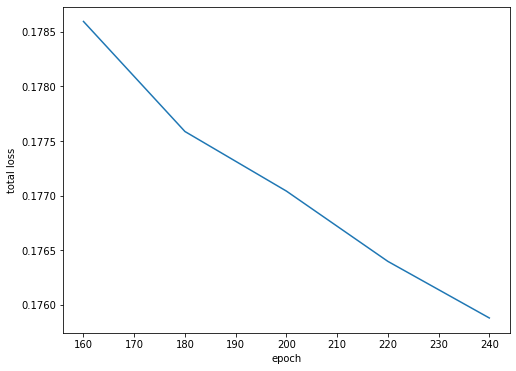

In [93]:
import json
tmet = json.load(open(f'{base}{model_folder}train_metrics.json'))

eps, loss = [], []
for m in tmet:
    eps.append(m.get('epoch'))
    loss.append(m.get('epoch_loss'))
plt.figure(figsize=(8, 6))
plt.plot(eps, loss);
plt.xlabel('epoch')
plt.ylabel('total loss');
# plt.title('model trained with SGD (lr: 0.001  momentum: 0.9)');

In [22]:
with open('/HDD/vxm-models/structured-data/filtered_images.pkl', 'rb') as f:
    pre_images = pickle.load(f)

with open('/HDD/vxm-models/structured-data/filtered_labels.pkl', 'rb') as f:
    pre_labels = pickle.load(f)

images, labels = [], []
for ind, img in pre_images.items():
    inp = torch.from_numpy(img)
    p_inp = torch.nn.functional.pad(inp, pad=(0, 0, 0, 0, 0, 40 - inp.shape[0]), mode='constant', value=0)
    images.append(p_inp)

for ind, img in pre_labels.items():
    inp = torch.from_numpy(img)
    p_inp = torch.nn.functional.pad(inp, pad=(0, 0, 0, 0, 0, 40 - inp.shape[0]), mode='constant', value=0)
    labels.append(p_inp)    

# Normalize        
for i, img in enumerate(images):
    print(img.shape)
    images[i] = (img/img.max()).float()

for i, lb in enumerate(labels):
    labels[i] = (lb/lb.max()).float()

In [48]:
with open('/HDD/vxm-models/structured-data/filtered_images.pkl', 'rb') as f:
    pre_images = pickle.load(f)
with open('/HDD/vxm-models/structured-data/filtered_labels.pkl', 'rb') as f:
    pre_labels = pickle.load(f)
    
images, labels = [], []
for ind, img in pre_images.items():
    images.append(torch.from_numpy(img))
for ind, img in pre_labels.items():
    labels.append(torch.from_numpy(img))
       
for i, img in enumerate(images):
    images[i] = (img/img.max()).float()
for i, lb in enumerate(labels):
    labels[i] = (lb/lb.max()).float()

In [21]:
# last_real = 23
# for f, t in zip(np.arange(last_real + 1 - 5), np.arange(5, last_real + 1)):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
#     ax1.imshow(images[0][t])
#     ax2.imshow(images[0][f])

In [106]:
def check_eq(a, b):
    if len(a) != len(b):
        return False
    for i, el in enumerate(a):
        if b[i] != el:
            return False
    return True
    


def dice(y_true, y_pred):
    eq_dices, neq_dices = [], []
    for i in range(y_true.shape[0] - 1):
        a, b = y_true[i], y_pred[i]
        
        zero = torch.zeros_like(a)
        one = torch.ones_like(a)
        c = torch.where(a > 0, one, zero)
        d = torch.where(b > 0, one, zero)
        top = 2 * np.multiply(c, d).sum()
        bottom = c.sum() + d.sum()
        if check_eq(np.unique(a), np.unique(b)):
            eq_dices.append((top / bottom).item())
        else:
            neq_dices.append((top / bottom).item())
    return eq_dices, neq_dices

In [107]:
all_eq, all_neq = [], []
for i, pl in enumerate(labels):
    last_real = None
    for j, s in enumerate(pl):
        if s.max() == 0:
            last_real = j - 1
            break
    
    y_true = labels[i][:last_real]
    y_pred = labels[i][1:last_real + 1]
    
    eq, neq = dice(y_true, y_pred)
    all_eq += eq
    all_neq += neq

0.7875215948742127


/home/khalili/.local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/khalili/.local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


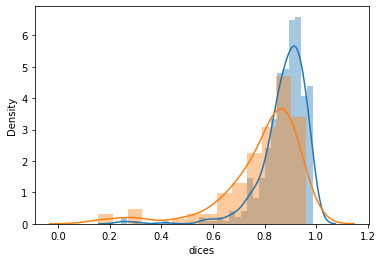

In [128]:
import seaborn as sns
import pandas as pd

data = pd.DataFrame()
data['dices'] = all_eq + all_neq
data['same'] = [1 for _ in range(len(all_eq))] + [0 for _ in range(len(all_neq))]
sns.distplot(data.dices[data.same==1]);
sns.distplot(data.dices[data.same==0]);
print(np.mean(all_neq))